In [ ]:
# !pip install googletrans==3.1.0a0

In [1]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

train_data_path = "/content/drive/MyDrive/HWe_Q2/train.csv"
test_data_path = "/content/drive/MyDrive/HWe_Q2/test.csv"

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

Mounted at /content/drive


In [2]:
train_data.columns = ['text' , 'label']
test_data.columns = ['text' , 'label']

# data.head()
# data.count()
train_data.head()

,text,label
0,سلام خيلي خوبه بخرين.,2
1,از جمله قابلیت‌های ارتباطی HTC Desire SV می‌تو...,0
2,نهایتا، یک دوربین VGA نیز برای انجام مکالمات ...,0
3,من حدوداً ۱ ماهي‌ که مي‌شه اين گوشي رو دارم، ر...,1
4,اندازه نسبتاً مناسب و وزن خوب 4.,1


# BackTranslation is Done and the Results are saved in augmented_dataset.csv


In [ ]:
# from googletrans import Translator, LANGUAGES
# import random

# translator = Translator()
# data2 = train_data

# for index , row in train_data.iterrows():
#   if row['label'] == 2:
#     row['label'] = 1

#   if row['label'] == -2:
#     row['label'] = -1

# def back_translate(text, intermediate_lang='fa'):
#     translated = translator.translate(text, dest=intermediate_lang).text

#     back_translated = translator.translate(translated, dest='en').text
#     if random.randint(1 , 4000) == 49:
#       print(f'translated : {translated} \n back_translated : {back_translated}')
#       print('-------------------------')
#     return back_translated


# data2['augmented_text'] = data2['text'].apply(lambda x: back_translate(x))

# data2.to_csv('/content/drive/MyDrive/HWe_Q2/augmented_dataset.csv', index=False)

# Before Augmenting Data

In [ ]:
# !pip install transformers
# !pip install accelerate

In [ ]:
# !pip show transformers
# !pip show accelerate


In [ ]:
# !pip install git+https://github.com/huggingface/accelerate
# !pip install accelerate[torch]

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_scheduler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# !pip install transformers torch sklearn matplotlib tqdm
# !pip install sklearn

In [ ]:
# !export CUDA_LAUNCH_BLOCKING=1

# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
train_data = pd.read_csv(train_data_path)
train_data.columns = ['text' , 'label']

train_data['label'] = train_data['label'].replace({-2 : -1 , 2 : 1})
train_data['label'] = train_data['label'] + 1  # Adjust labels to 0, 1, 2 if they were -1, 0, 1

unique_labels = train_data['label'].unique()

# Print the unique label values
print(f'unique_labels : {unique_labels}')

unique_labels : [2 1 0]


In [ ]:
# !export TORCH_USE_CUDA_DSA=1

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_scheduler
import torch
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len = 128):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = int(self.labels[item])

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens = True,
            max_length = self.max_len,
            return_token_type_ids = False,
            padding='max_length',
            return_attention_mask = True,
            return_tensors = 'pt',
            truncation = True
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


tokenizer = BertTokenizer.from_pretrained('sbunlp/fabert')
model = BertForSequenceClassification.from_pretrained('sbunlp/fabert', num_labels=3)

for name, param in model.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = False


train_dataset = TextDataset(train_data['text'], train_data['label'], tokenizer)
val_dataset = TextDataset(val_data['text'], val_data['label'], tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Move model to GPU if available
# device = torch.device("cpu")
# device = torch.device('cuda:0')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("CUDA available : ", torch.cuda.is_available())
print("Device being used : ", device)

model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Train and Evaluate
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0

    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        labels = d['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    average_loss = total_loss / len(data_loader)
    accuracy = correct_predictions.double() / len(data_loader.dataset)
    return accuracy, average_loss

def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)

    average_loss = total_loss / len(data_loader)
    accuracy = correct_predictions.double() / len(data_loader.dataset)
    return accuracy, average_loss

# Training and validation loop
history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}
epochs = 15

for epoch in range(epochs):
    train_acc, train_loss = train_epoch(model, train_loader, optimizer, device)
    val_acc, val_loss = evaluate(model, val_loader, device)
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    print(f'Epoch {epoch + 1}/{epochs}, Train Acc: {train_acc:.2f}, Train Loss: {train_loss:.2f}, Val Acc: {val_acc:.2f}, Val Loss: {val_loss:.2f}')



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sbunlp/fabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


CUDA available :  True
Device being used :  cuda
Epoch 1/15, Train Acc: 0.40, Train Loss: 1.09, Val Acc: 0.44, Val Loss: 1.08
Epoch 2/15, Train Acc: 0.44, Train Loss: 1.07, Val Acc: 0.46, Val Loss: 1.06
Epoch 3/15, Train Acc: 0.44, Train Loss: 1.05, Val Acc: 0.45, Val Loss: 1.04
Epoch 4/15, Train Acc: 0.44, Train Loss: 1.04, Val Acc: 0.45, Val Loss: 1.02
Epoch 5/15, Train Acc: 0.45, Train Loss: 1.03, Val Acc: 0.45, Val Loss: 1.01
Epoch 6/15, Train Acc: 0.46, Train Loss: 1.02, Val Acc: 0.46, Val Loss: 1.00
Epoch 7/15, Train Acc: 0.47, Train Loss: 1.01, Val Acc: 0.47, Val Loss: 0.99
Epoch 8/15, Train Acc: 0.47, Train Loss: 1.00, Val Acc: 0.47, Val Loss: 0.98
Epoch 9/15, Train Acc: 0.47, Train Loss: 0.99, Val Acc: 0.47, Val Loss: 0.97
Epoch 10/15, Train Acc: 0.46, Train Loss: 0.98, Val Acc: 0.47, Val Loss: 0.97
Epoch 11/15, Train Acc: 0.48, Train Loss: 0.98, Val Acc: 0.47, Val Loss: 0.96
Epoch 12/15, Train Acc: 0.48, Train Loss: 0.98, Val Acc: 0.48, Val Loss: 0.96
Epoch 13/15, Train Acc: 

In [8]:
def convert_to_numpy(data):
    return [item.cpu().numpy() if isinstance(item, torch.Tensor) else item for item in data]

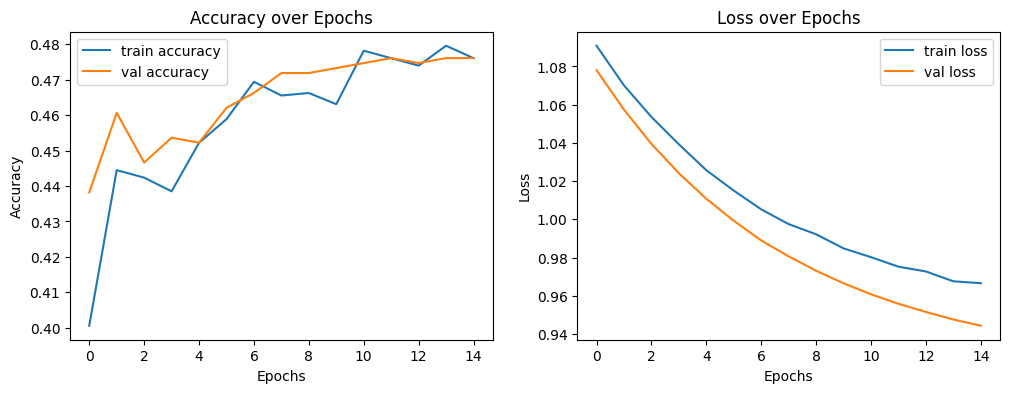

Confusion Matrix:
 [[  0   2  56]
 [  0  15 312]
 [  0   3 324]]
F1 Score: 0.3317639572088483


In [ ]:
train_acc = history['train_acc']
val_acc = history['val_acc']

train_loss = history['train_loss']
val_loss = history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(convert_to_numpy(train_acc) , label='train accuracy')
plt.plot(convert_to_numpy(val_acc) , label='val accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)

plt.plot(convert_to_numpy(train_loss) , label='train loss')
plt.plot(convert_to_numpy(val_loss) , label='val loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


y_pred, y_true = [], []
model.eval()

with torch.no_grad():
    for d in val_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        labels = d['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
print('Confusion Matrix:\n', conf_matrix)
print('F1 Score:', f1)

# FaBert on Augmeted Data

In [3]:
path2 = '/content/drive/MyDrive/HWe_Q2/augmented_dataset.csv'

data2 = pd.read_csv(path2)

data2.head()

,text,label,augmented_text
0,سلام خيلي خوبه بخرين.,2,"Hello, buy it very well."
1,از جمله قابلیت‌های ارتباطی HTC Desire SV می‌تو...,0,Among the communication capabilities of HTC De...
2,نهایتا، یک دوربین VGA نیز برای انجام مکالمات ...,0,"Finally, a VGA camera is also installed on the..."
3,من حدوداً ۱ ماهي‌ که مي‌شه اين گوشي رو دارم، ر...,1,I have had this phone for about 1 month and I ...
4,اندازه نسبتاً مناسب و وزن خوب 4.,1,Fairly good size and good weight 4.


In [4]:
import pandas as pd

new_rows = []

for index, row in data2.iterrows():
    new_row = {
        'text': row['augmented_text'],
        'label': row['label'],
        'augmented_text': None
    }
    new_rows.append(new_row)
    new_rows.append(row)

new_data = pd.DataFrame(new_rows, columns=['text', 'label', 'augmented_text'])

new_data.head()

,text,label,augmented_text
0,"Hello, buy it very well.",2,None
1,سلام خيلي خوبه بخرين.,2,"Hello, buy it very well."
2,Among the communication capabilities of HTC De...,0,None
3,از جمله قابلیت‌های ارتباطی HTC Desire SV می‌تو...,0,Among the communication capabilities of HTC De...
4,"Finally, a VGA camera is also installed on the...",0,None


In [5]:
new_data['label'] = new_data['label'].replace({-2 : -1 , 2 : 1})
new_data['label'] = new_data['label'] + 1


unique_labels = new_data['label'].unique()


print(f'unique_labels : {unique_labels}')

unique_labels : [2 1 0]


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_scheduler
import torch
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

new_data['label'] = new_data['label'].replace({-2 : -1 , 2 : 1})
new_data['label'] = new_data['label'] + 1

train_data, val_data = train_test_split(new_data , test_size=0.2 , random_state=42)

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len = 128):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = int(self.labels[item])

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens = True,
            max_length = self.max_len,
            return_token_type_ids = False,
            padding='max_length',
            return_attention_mask = True,
            return_tensors = 'pt',
            truncation = True
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


tokenizer = BertTokenizer.from_pretrained('sbunlp/fabert')
model = BertForSequenceClassification.from_pretrained('sbunlp/fabert', num_labels=3)

for name, param in model.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = False


train_dataset = TextDataset(train_data['text'], train_data['label'], tokenizer)
val_dataset = TextDataset(val_data['text'], val_data['label'], tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Move model to GPU if available
# device = torch.device("cpu")
# device = torch.device('cuda:0')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("CUDA available : ", torch.cuda.is_available())
print("Device being used : ", device)

model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Train and Evaluate
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0

    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        labels = d['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    average_loss = total_loss / len(data_loader)
    accuracy = correct_predictions.double() / len(data_loader.dataset)
    return accuracy, average_loss

def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)

    average_loss = total_loss / len(data_loader)
    accuracy = correct_predictions.double() / len(data_loader.dataset)
    return accuracy, average_loss

# Training and validation loop
history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}
epochs = 15

for epoch in range(epochs):
    train_acc, train_loss = train_epoch(model, train_loader, optimizer, device)
    val_acc, val_loss = evaluate(model, val_loader, device)
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    print(f'Epoch {epoch + 1}/{epochs}, Train Acc: {train_acc:.2f}, Train Loss: {train_loss:.2f}, Val Acc: {val_acc:.2f}, Val Loss: {val_loss:.2f}')



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/18.3k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/552k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/589 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sbunlp/fabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CUDA available :  True
Device being used :  cuda


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/15, Train Acc: 0.87, Train Loss: 0.95, Val Acc: 0.90, Val Loss: 0.85
Epoch 2/15, Train Acc: 0.90, Train Loss: 0.77, Val Acc: 0.90, Val Loss: 0.69
Epoch 3/15, Train Acc: 0.90, Train Loss: 0.63, Val Acc: 0.90, Val Loss: 0.58
Epoch 4/15, Train Acc: 0.90, Train Loss: 0.54, Val Acc: 0.90, Val Loss: 0.51
Epoch 5/15, Train Acc: 0.90, Train Loss: 0.48, Val Acc: 0.90, Val Loss: 0.46
Epoch 6/15, Train Acc: 0.90, Train Loss: 0.44, Val Acc: 0.90, Val Loss: 0.42
Epoch 7/15, Train Acc: 0.90, Train Loss: 0.41, Val Acc: 0.90, Val Loss: 0.40
Epoch 8/15, Train Acc: 0.90, Train Loss: 0.39, Val Acc: 0.90, Val Loss: 0.39
Epoch 9/15, Train Acc: 0.90, Train Loss: 0.37, Val Acc: 0.90, Val Loss: 0.38
Epoch 10/15, Train Acc: 0.90, Train Loss: 0.36, Val Acc: 0.90, Val Loss: 0.37
Epoch 11/15, Train Acc: 0.90, Train Loss: 0.36, Val Acc: 0.90, Val Loss: 0.36
Epoch 12/15, Train Acc: 0.90, Train Loss: 0.35, Val Acc: 0.90, Val Loss: 0.36
Epoch 13/15, Train Acc: 0.90, Train Loss: 0.35, Val Acc: 0.90, Val Loss: 

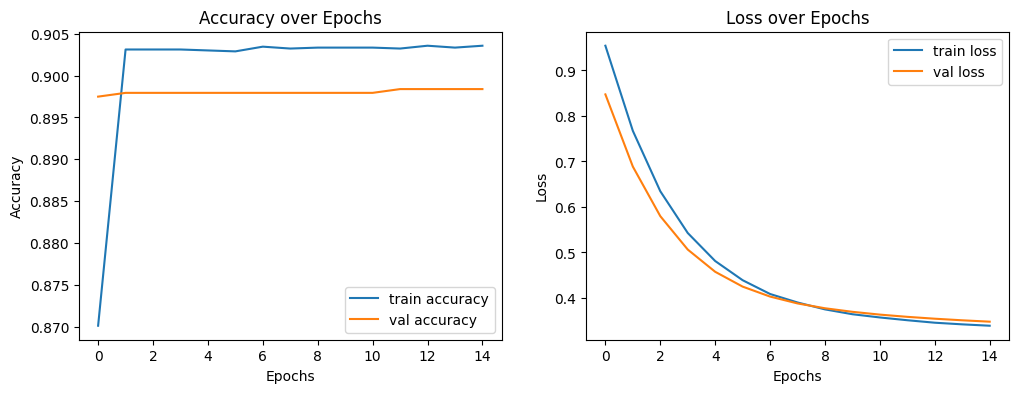

Confusion Matrix:
 [[   0  226]
 [   0 1998]]
F1 Score: 0.8502917230403265


In [9]:
train_acc = history['train_acc']
val_acc = history['val_acc']

train_loss = history['train_loss']
val_loss = history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(convert_to_numpy(train_acc) , label='train accuracy')
plt.plot(convert_to_numpy(val_acc) , label='val accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)

plt.plot(convert_to_numpy(train_loss) , label='train loss')
plt.plot(convert_to_numpy(val_loss) , label='val loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


y_pred, y_true = [], []
model.eval()

with torch.no_grad():
    for d in val_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        labels = d['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
print('Confusion Matrix:\n', conf_matrix)
print('F1 Score:', f1)

In [14]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

test_data['label'] = test_data['label'].replace({-2 : -1 , 2 : 1})
test_data['label'] = test_data['label'] + 1

test_dataset = TextDataset(test_data['text'], test_data['label'], tokenizer)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

def test_model(model, data_loader, device):
    model.eval()
    y_pred = []
    y_true = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)

            outputs = model(input_ids = input_ids, attention_mask = attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)

            # Collect all predictions and labels
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    return y_true, y_pred


y_true, y_pred = test_model(model, test_loader, device)


conf_matrix = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
class_report = classification_report(y_true, y_pred)

print("Confusion Matrix:\n", conf_matrix)
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Classification Report:\n", class_report)

Confusion Matrix:
 [[  0   0 196]
 [  1   0 742]
 [  0   0 914]]
Accuracy: 49.33%
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       196
           1       0.00      0.00      0.00       743
           2       0.49      1.00      0.66       914

    accuracy                           0.49      1853
   macro avg       0.16      0.33      0.22      1853
weighted avg       0.24      0.49      0.33      1853



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Testing2

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = str(self.data.iloc[index]['text'])
        label = self.data.iloc[index]['label']
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Assuming train_data and test_data are already defined as pandas DataFrames
train_data, valid_data = train_test_split(train_data, test_size=0.1, random_state=42)

train_dataset = CustomDataset(train_data, tokenizer)
valid_dataset = CustomDataset(valid_data, tokenizer)
test_dataset = CustomDataset(test_data, tokenizer)


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
def train(model, train_loader, valid_loader, epochs=10, learning_rate=2e-5):
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_loader) * epochs
    scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    criterion = torch.nn.CrossEntropyLoss()
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(epochs):
        # Training
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(total_train_loss / len(train_loader))
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        model.eval()
        total_valid_loss = 0
        correct_valid = 0
        total_valid = 0

        with torch.no_grad():
            for batch in valid_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss

                total_valid_loss += loss.item()
                _, predicted = torch.max(outputs.logits, 1)
                correct_valid += (predicted == labels).sum().item()
                total_valid += labels.size(0)

        valid_losses.append(total_valid_loss / len(valid_loader))
        valid_accuracy = correct_valid / total_valid
        valid_accuracies.append(valid_accuracy)

        # Print progress
        print(f'Epoch {epoch + 1}/{epochs}, '
              f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Valid Loss: {valid_losses[-1]:.4f}, Valid Acc: {valid_accuracy:.4f}')

    return train_losses, valid_losses, train_accuracies, valid_accuracies

def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_accuracy = correct / total
    print(f'Test Accuracy: {test_accuracy:.4f}')
    return test_accuracy

In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
torch.cuda.set_device(device)
CUDA_LAUNCH_BLOCKING=1

train_losses, valid_losses, train_accuracies, valid_accuracies = train(model, train_loader, valid_loader, epochs=10)

test_accuracy = evaluate(model, test_loader)

In [ ]:
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train')
plt.plot(range(1, len(valid_accuracies) + 1), valid_accuracies, label='Valid')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Valid')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Testing

In [ ]:
results = trainer.evaluate()
print(results)

In [ ]:
# Load the pre-trained FaBert model
model = BertForSequenceReadingComprehension.from_pretrained('sbunlp/fabert', num_labels=3)

# Freeze all layers except the last one
for param in model.bert.parameters():
    param.requires_grad = False

# Make sure the classifier layer is not frozen
for param in model.classifier.parameters():
    param.requires_grad = True

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# Evaluation function to include accuracy and return predictions and references
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    conf_mat = confusion_matrix(labels, preds)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'confusion_matrix': conf_mat
    }


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_original,
    eval_dataset=tokenized_augmented,
    compute_metrics=compute_metrics
)


trainer.train()


final_results = trainer.evaluate()
print("Final accuracy : ", final_results['eval_accuracy'])
print("Confusion matrix : \n", final_results['eval_confusion_matrix'])


history = trainer.state.log_history


epochs = len(history)
accuracy = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]
train_loss = [x['loss'] for x in history if 'loss' in x]


plt.figure(figsize=(10, 5))
plt.plot(range(epochs), accuracy, label='Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_loss, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Get predictions and true labels
predictions = np.argmax(trainer.predict(tokenized_augmented).predictions, axis=-1)
true_labels = tokenized_augmented['labels']

# Find incorrect samples
incorrect_indices = np.where(predictions != true_labels)[0]
incorrect_samples = tokenized_augmented.select(incorrect_indices)

print("Some incorrectly tagged samples:")
for sample in incorrect_samples[:5]:
    print("Text:", sample['text'])
    print("Predicted:", predictions[sample['index']])
    print("True Label:", sample['label'])


# Augmenting Data

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split

tokenizer = BertTokenizer.from_pretrained('sbunlp/fabert')
model = BertForSequenceClassification.from_pretrained('sbunlp/fabert', num_labels=3)

def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True, max_length=512)

original_dataset = data[['text_column', 'label_column']].rename(columns={'text_column': 'text'})
augmented_dataset = data[['augmented_text', 'label_column']].rename(columns={'augmented_text': 'text'})

# Merge original_dataset and augmented_dataset
combined_dataset = pd.concat([original_dataset, augmented_dataset], ignore_index=True)

tokenized_combined = combined_dataset.map(preprocess_function, batched=True)

# Split the combined dataset into train, validation, and test sets
train_data, val_test_data = train_test_split(tokenized_combined, test_size=0.2)
val_data, test_data = train_test_split(val_test_data, test_size=0.5)

training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/HWe_Q2/results_1',
    evaluation_strategy="epoch",
    learning_rate=10e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data
)

trainer.train()

model.save_pretrained('/content/drive/MyDrive/HWe_Q2/fabert_finetuned')

In [ ]:
results = trainer.evaluate()
print(results)

In [ ]:
# Load the pre-trained FaBert model
model = BertForSequenceReadingComprehension.from_pretrained('sbunlp/fabert', num_labels=3)

# Freeze all layers except the last one
for param in model.bert.parameters():
    param.requires_grad = False

# Make sure the classifier layer is not frozen
for param in model.classifier.parameters():
    param.requires_grad = True

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# Evaluation function to include accuracy and return predictions and references
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    conf_mat = confusion_matrix(labels, preds)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'confusion_matrix': conf_mat
    }


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_original,
    eval_dataset=tokenized_augmented,
    compute_metrics=compute_metrics
)


trainer.train()


final_results = trainer.evaluate()
print("Final accuracy : ", final_results['eval_accuracy'])
print("Confusion matrix : \n", final_results['eval_confusion_matrix'])


history = trainer.state.log_history


epochs = len(history)
accuracy = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]
train_loss = [x['loss'] for x in history if 'loss' in x]


plt.figure(figsize=(10, 5))
plt.plot(range(epochs), accuracy, label='Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_loss, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Get predictions and true labels
predictions = np.argmax(trainer.predict(tokenized_augmented).predictions, axis=-1)
true_labels = tokenized_augmented['labels']

# Find incorrect samples
incorrect_indices = np.where(predictions != true_labels)[0]
incorrect_samples = tokenized_augmented.select(incorrect_indices)

print("Some incorrectly tagged samples:")
for sample in incorrect_samples[:5]:
    print("Text:", sample['text'])
    print("Predicted:", predictions[sample['index']])
    print("True Label:", sample['label'])
